In [1]:
#import libraries
import math
import numpy as np
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Concatenate
from keras import optimizers
from keras.utils import plot_model
import matplotlib.pyplot as plt
from ta.utils import dropna
from supertrend import ST

Using Theano backend.
/home/aryan/miniconda3/envs/dlfa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aryan/miniconda3/envs/dlfa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aryan/miniconda3/envs/dlfa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aryan/miniconda3/envs/dl

In [2]:
def read_csv(csv_path):
    data = pd.read_csv(csv_path)
    data = dropna(data)
    return data

In [3]:
DAILY = False
if DAILY == True:
    data = read_csv('AMZN_daily.csv')
else:
    data = read_csv('AMZNintraday.csv')
print(data.tail())

                     date  1. open  2. high   3. low  4. close  5. volume
1932  2020-06-29 05:57:00  2700.07  2700.07  2700.00   2700.00      419.0
1933  2020-06-29 05:55:00  2700.00  2700.00  2700.00   2700.00      268.0
1934  2020-06-29 05:51:00  2699.99  2699.99  2699.99   2699.99      200.0
1935  2020-06-29 04:13:00  2700.50  2700.50  2700.50   2700.50      350.0
1936  2020-06-29 04:01:00  2700.10  2700.10  2700.10   2700.10      126.0


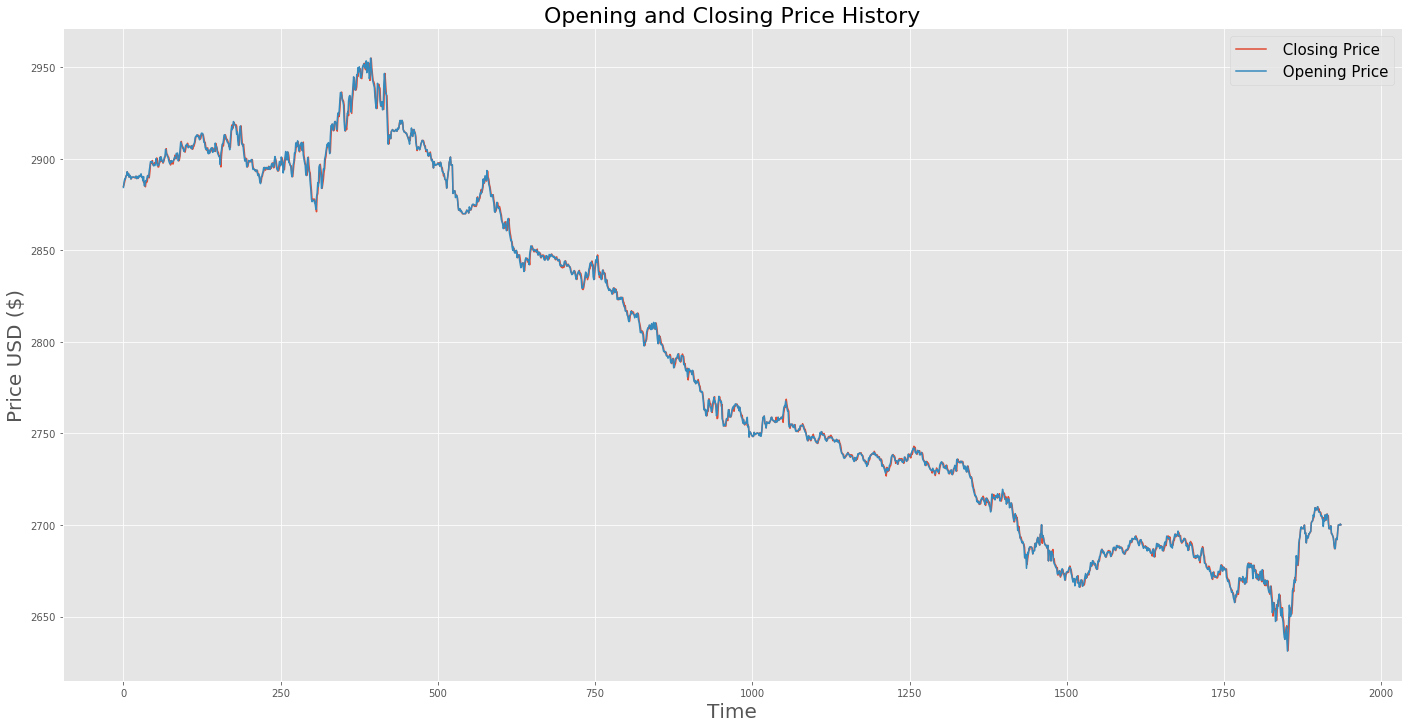

In [4]:
plt.style.use('ggplot')
plt.figure(figsize=(24,12))
plt.title('Opening and Closing Price History', fontsize=22)
plt.plot(data['4. close'], label=' Closing Price')
plt.plot(data['1. open'], label=' Opening Price')
plt.xlabel('Time',fontsize=20)
plt.ylabel('Price USD ($)',fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [5]:
#Extracting the data to be trained upon
close_data = data.filter(['4. close'])
dataset = close_data.values
train_len = math.ceil(len(dataset)*0.85)
# train_len
print(close_data)

      4. close
0      2885.00
1      2886.01
2      2887.51
3      2889.00
4      2890.50
...        ...
1932   2700.00
1933   2700.00
1934   2699.99
1935   2700.50
1936   2700.10

[1937 rows x 1 columns]


In [6]:
#Normalising the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
# scaled_data
O_scaler = MinMaxScaler(feature_range=(0,1))
dataset[:,0].shape
scaled_output = O_scaler.fit_transform(np.reshape(dataset[:,0],(dataset.shape[0],1)))

In [7]:
history = 50 # number of data points to be used for prediction
train_data = scaled_data[0:train_len]
test_data = scaled_data[train_len-history:]
print(train_data.shape,test_data.shape)

(1647, 1) (340, 1)


In [8]:
# Creating the training data
x_train = []
y_train = []
for x in range(history,len(train_data)):
    x_train.append(train_data[x-history:x])
    y_train.append(train_data[x,0])
x_train,y_train = np.array(x_train),np.array(y_train)

x_test = []
for x in range(history,len(test_data)):
    x_test.append(test_data[x-history:x])
x_test = np.array(x_test)
y_test = dataset[train_len:,0]

y_train = np.reshape(y_train,(y_train.shape[0],1))
y_test = np.reshape(y_test,(y_test.shape[0],1))
y_train.shape

(1597, 1)

In [9]:
def model_daily(x_train):
    #Building the model
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1:])))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())

    model.add(LSTM(units=56, return_sequences=False))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())

    model.add(Dense(units=32))
    # model.add(BatchNormalization())
    model.add(Dense(units=1))
    
    #Compile the model
    model.compile(optimizer='adam', loss='mse')
    return model

In [10]:
if DAILY == True:
    model = model_daily(x_train)
    hist = model.fit(x_train, y_train, batch_size=1, epochs=20, validation_split = 0.05)

In [11]:
if DAILY == True:
    predictions = model.predict(x_test)
    predictions = O_scaler.inverse_transform(predictions)
    print(y_test.shape)

In [12]:
#Find Error
real_mse = np.mean(np.square(y_test - predictions))
print(real_mse)

NameError: name 'predictions' is not defined

NameError: name 'predictions' is not defined

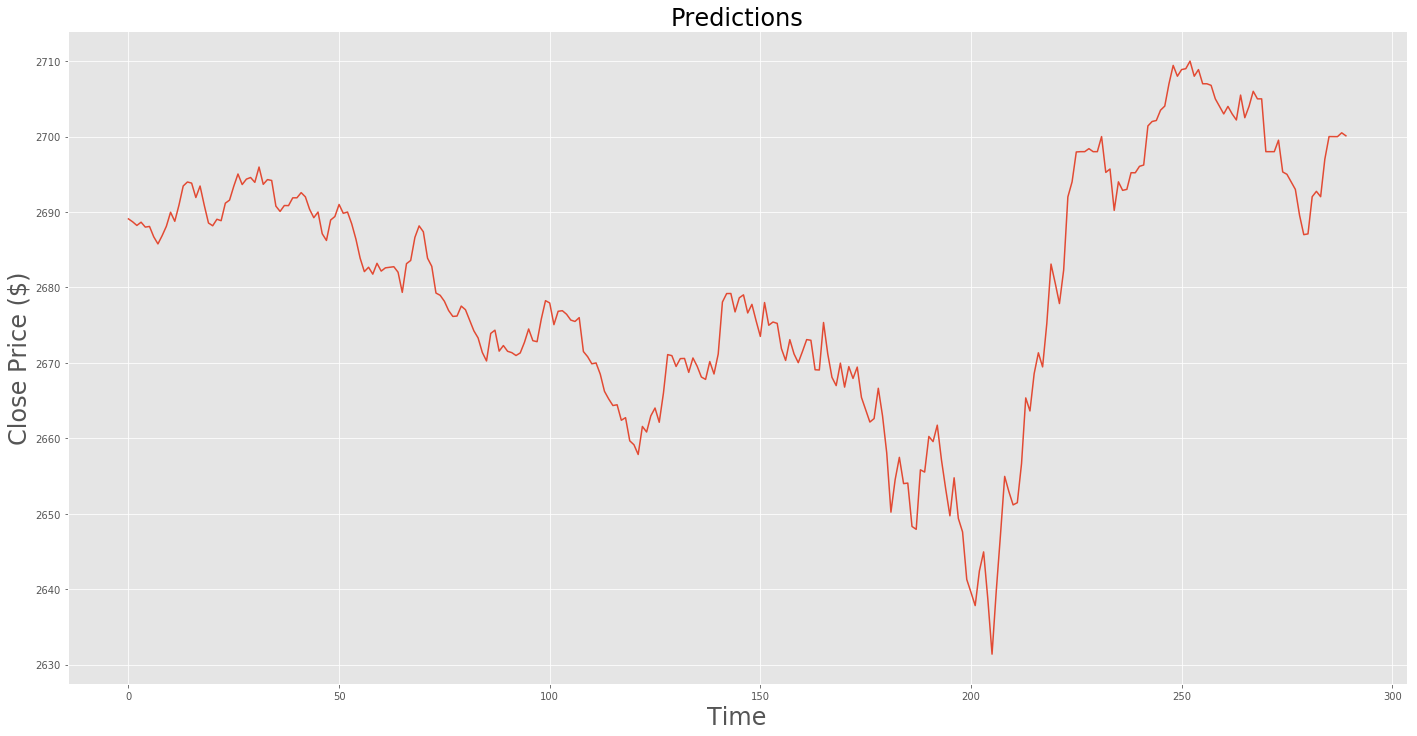

In [13]:
#plotting the results
ground_truth = np.array(close_data[train_len:])
ground_truth = np.expand_dims(ground_truth[:,0],-1)
plt.figure(figsize=(24,12))
plt.title('Predictions',fontsize = 24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Close Price ($)', fontsize=24)
plt.plot(ground_truth, label = "Actual Closing Price")
plt.plot(predictions, label = "Predicted Closing Price")
plt.legend(fontsize = 16)
plt.show()

In [14]:
def save_model(name):
    model.save(name+".h5")
    print("model saved")

In [16]:
#USing Technical Indicators
data['ADX'] = ta.trend.adx(data['2. high'], data['3. low'], data['4. close'], n = 20, fillna = True)
data['MACD'] = ta.trend.macd(data['4. close'], n_fast = 26 , n_slow = 12, fillna = True)
data['SMA'] = ta.trend.sma_indicator(data['4. close'], n = 10, fillna = True)
data = ST(data,3,7)
data.tail()

/home/aryan/stock_prediction/supertrend.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ATR'][i]=(df['ATR'][i-1]*(n-1)+ df['TR'][i])/n
/home/aryan/stock_prediction/supertrend.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Upper Band'][i]=min(df['Upper Basic'][i],df['Upper Band'][i-1])
/home/aryan/stock_prediction/supertrend.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Upper Band'][i]=df['Upper Basic'][i]


,date,1. open,2. high,3. low,4. close,5. volume,ADX,MACD,SMA,H-L,H-PC,L-PC,TR,ATR,Upper Basic,Lower Basic,Upper Band,Lower Band,SuperTrend
1932,2020-06-29 05:57:00,2700.07,2700.07,2700.00,2700.00,419.0,21.667852,1.837422,2692.448,0.07,3.06,2.99,3.06,2.433169,2707.334506,2692.735494,2697.690439,2692.735494,2692.735494
1933,2020-06-29 05:55:00,2700.00,2700.00,2700.00,2700.00,268.0,20.679315,1.287202,2693.048,0.00,0.00,0.00,0.00,2.085573,2706.256720,2693.743280,2706.256720,2693.743280,2693.743280
1934,2020-06-29 05:51:00,2699.99,2699.99,2699.99,2699.99,200.0,19.738809,0.842247,2693.747,0.00,0.01,0.01,0.01,1.789063,2705.357188,2694.622812,2705.357188,2694.622812,2694.622812
1935,2020-06-29 04:13:00,2700.50,2700.50,2700.50,2700.50,350.0,18.916428,0.443353,2694.840,0.00,0.51,0.51,0.51,1.606340,2705.319019,2695.680981,2705.319019,2695.680981,2695.680981
1936,2020-06-29 04:01:00,2700.10,2700.10,2700.10,2700.10,126.0,18.074110,0.157686,2696.150,0.00,0.40,0.40,0.40,1.434005,2704.402016,2695.797984,2704.402016,2695.797984,2695.797984


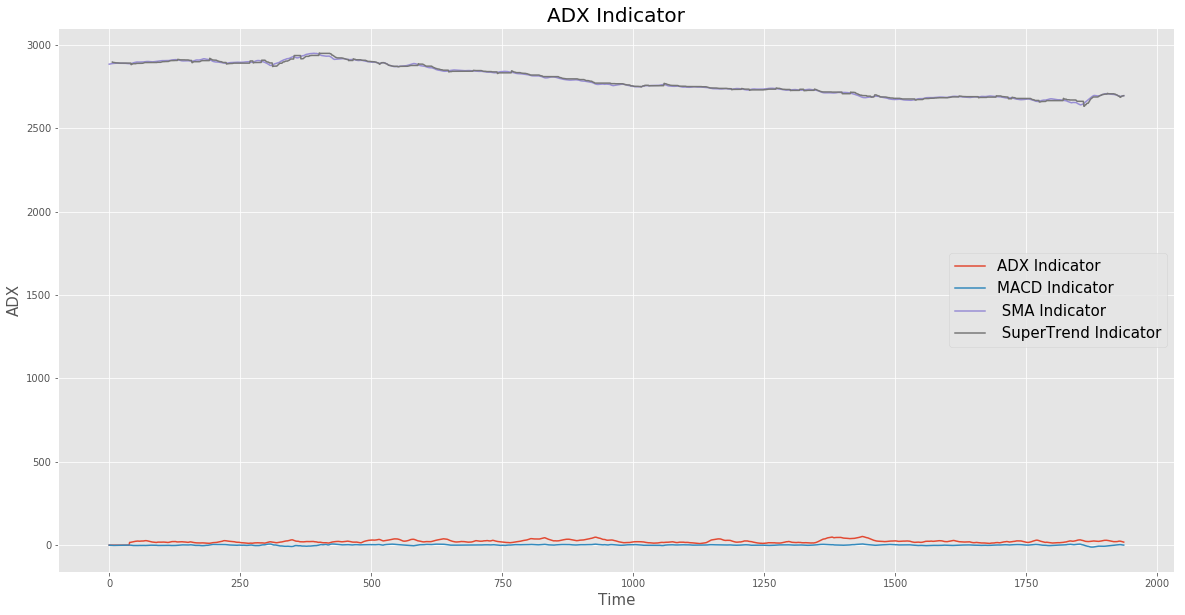

In [25]:
plt.figure(figsize = (20,10))
plt.title('ADX Indicator',fontsize = 20)
plt.plot(data['ADX'],label = 'ADX Indicator')
plt.plot(data['MACD'], label = 'MACD Indicator')
plt.plot(data['SMA'], label = ' SMA Indicator')
plt.plot(data['SuperTrend'], label = ' SuperTrend Indicator')
plt.xlabel('Time',fontsize = 15)
plt.ylabel('ADX',fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

In [27]:
#Scaling Technical Indicator
tech_ind_scaler = MinMaxScaler(feature_range=(0,1))
tech_ind_value = data.filter(['SuperTrend']).values
scaled_tech_ind = tech_ind_scaler.fit_transform(tech_ind_value)
scaled_tech_ind

array([[       nan],
       [       nan],
       [       nan],
       ...,
       [0.19450302],
       [0.19780679],
       [0.19817209]])

In [28]:
tech_ind_train = scaled_tech_ind[history:train_len]
tech_ind_test = scaled_tech_ind[train_len:]
tech_ind_train.shape

(1597, 1)

In [51]:
#Building concatenated model
def model_intraday(x_train,tech_ind_train):
    model_1 = Sequential()
    model_1.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1:])))
    # model_1.add(BatchNormalization())
    model_1.add(Dropout(0.2))


    model_1.add(LSTM(units=64, return_sequences=False))
    # model_1.add(BatchNormalization())
    # model_1.add(Dropout(0.2))
    # model_1.add(LSTM(units = 56,return_sequences = False))

    model_2 = Sequential()
    model_2.add(Dense(units = 64, input_shape=(tech_ind_train.shape[1],)))
    # model_2.add(BatchNormalization())
    model_2.add(Dropout(0.4))
    # model_2.add(Dense(units = 64, activation = 'relu'))
    # model_2.add(Dropout(0.2))

    concat = Concatenate()([model_1.output,model_2.output])

    output = Dense(64,activation = 'linear')(concat)
    output = Dense(1,activation = 'sigmoid')(output)

    model = Model([model_1.input,model_2.input],output)

    plot_model(model, show_shapes=True)
    
    #Compile the model
    opt = optimizers.Adam(lr=0.0005)
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

In [52]:
if DAILY == False:
    model = model_intraday(x_train,tech_ind_train)
    hist = model.fit([x_train,tech_ind_train], y_train, batch_size=3,epochs=40, validation_split = 0.05)

Train on 1517 samples, validate on 80 samples
Epoch 1/40
1517/1517 [==============================] - 16s 11ms/step - loss: 0.0055 - val_loss: 7.2117e-05
Epoch 2/40
1517/1517 [==============================] - 16s 10ms/step - loss: 8.1633e-04 - val_loss: 2.2865e-04
Epoch 3/40
1517/1517 [==============================] - 16s 10ms/step - loss: 6.4193e-04 - val_loss: 0.0012
Epoch 4/40
1517/1517 [==============================] - 16s 10ms/step - loss: 4.6975e-04 - val_loss: 9.7600e-05
Epoch 5/40
1517/1517 [==============================] - 16s 10ms/step - loss: 4.4872e-04 - val_loss: 3.8809e-04
Epoch 6/40
1517/1517 [==============================] - 16s 10ms/step - loss: 4.0374e-04 - val_loss: 1.3218e-04
Epoch 7/40
1517/1517 [==============================] - 16s 10ms/step - loss: 3.7826e-04 - val_loss: 5.9481e-05
Epoch 8/40
1517/1517 [==============================] - 16s 10ms/step - loss: 3.6541e-04 - val_loss: 3.8045e-05
Epoch 9/40
1517/1517 [==============================] - 16s 10ms/s

In [47]:
if DAILY == False:
    predictions = model.predict([x_test,tech_ind_test])
    predictions = O_scaler.inverse_transform(predictions)

In [48]:
#Find Error
real_mse = np.mean(np.square(y_test - predictions))
real_mse

63.50590560623803

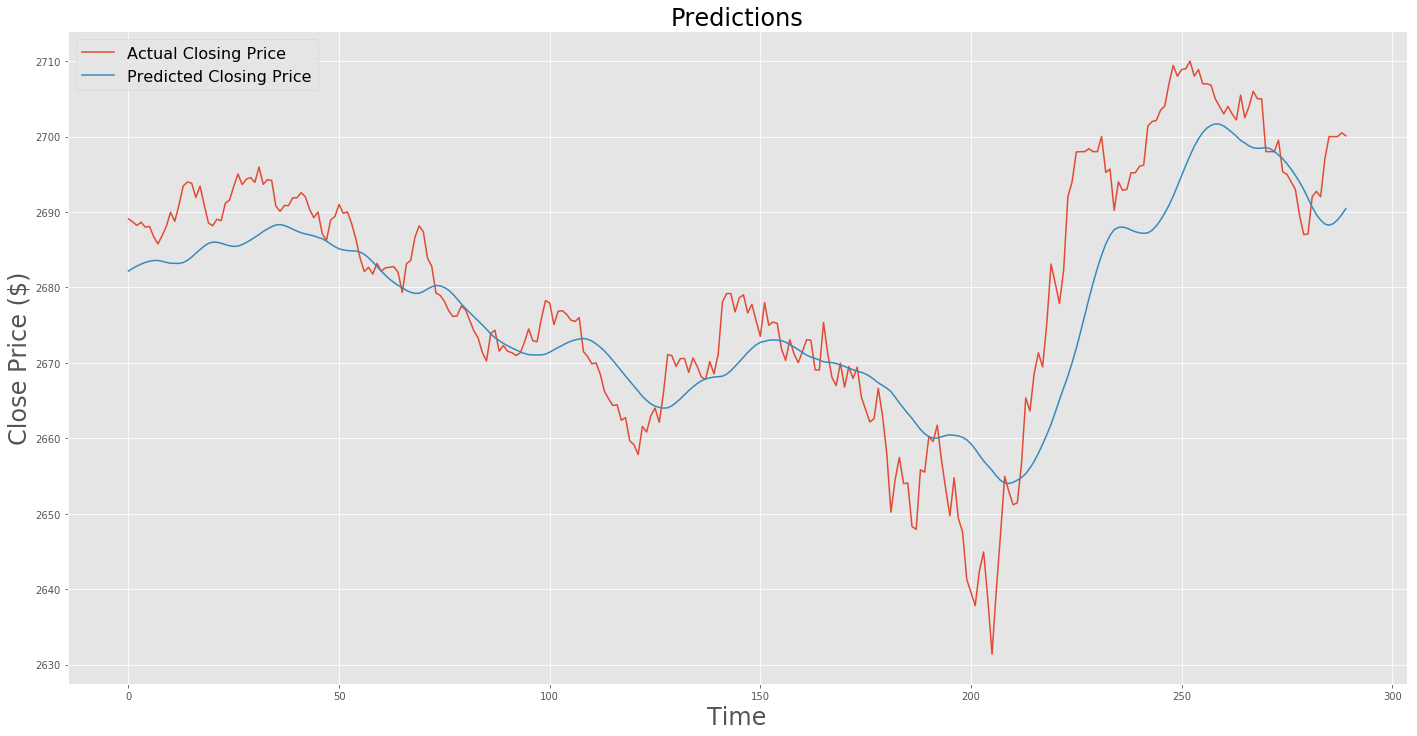

In [49]:
#plotting the results
ground_truth = np.array(close_data[train_len:])
ground_truth = np.expand_dims(ground_truth[:,0],-1)
plt.figure(figsize=(24,12))
plt.title('Predictions',fontsize = 24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Close Price ($)', fontsize=24)
plt.plot(ground_truth, label = "Actual Closing Price")
plt.plot(predictions, label = "Predicted Closing Price")
plt.legend(fontsize = 16)
plt.show()